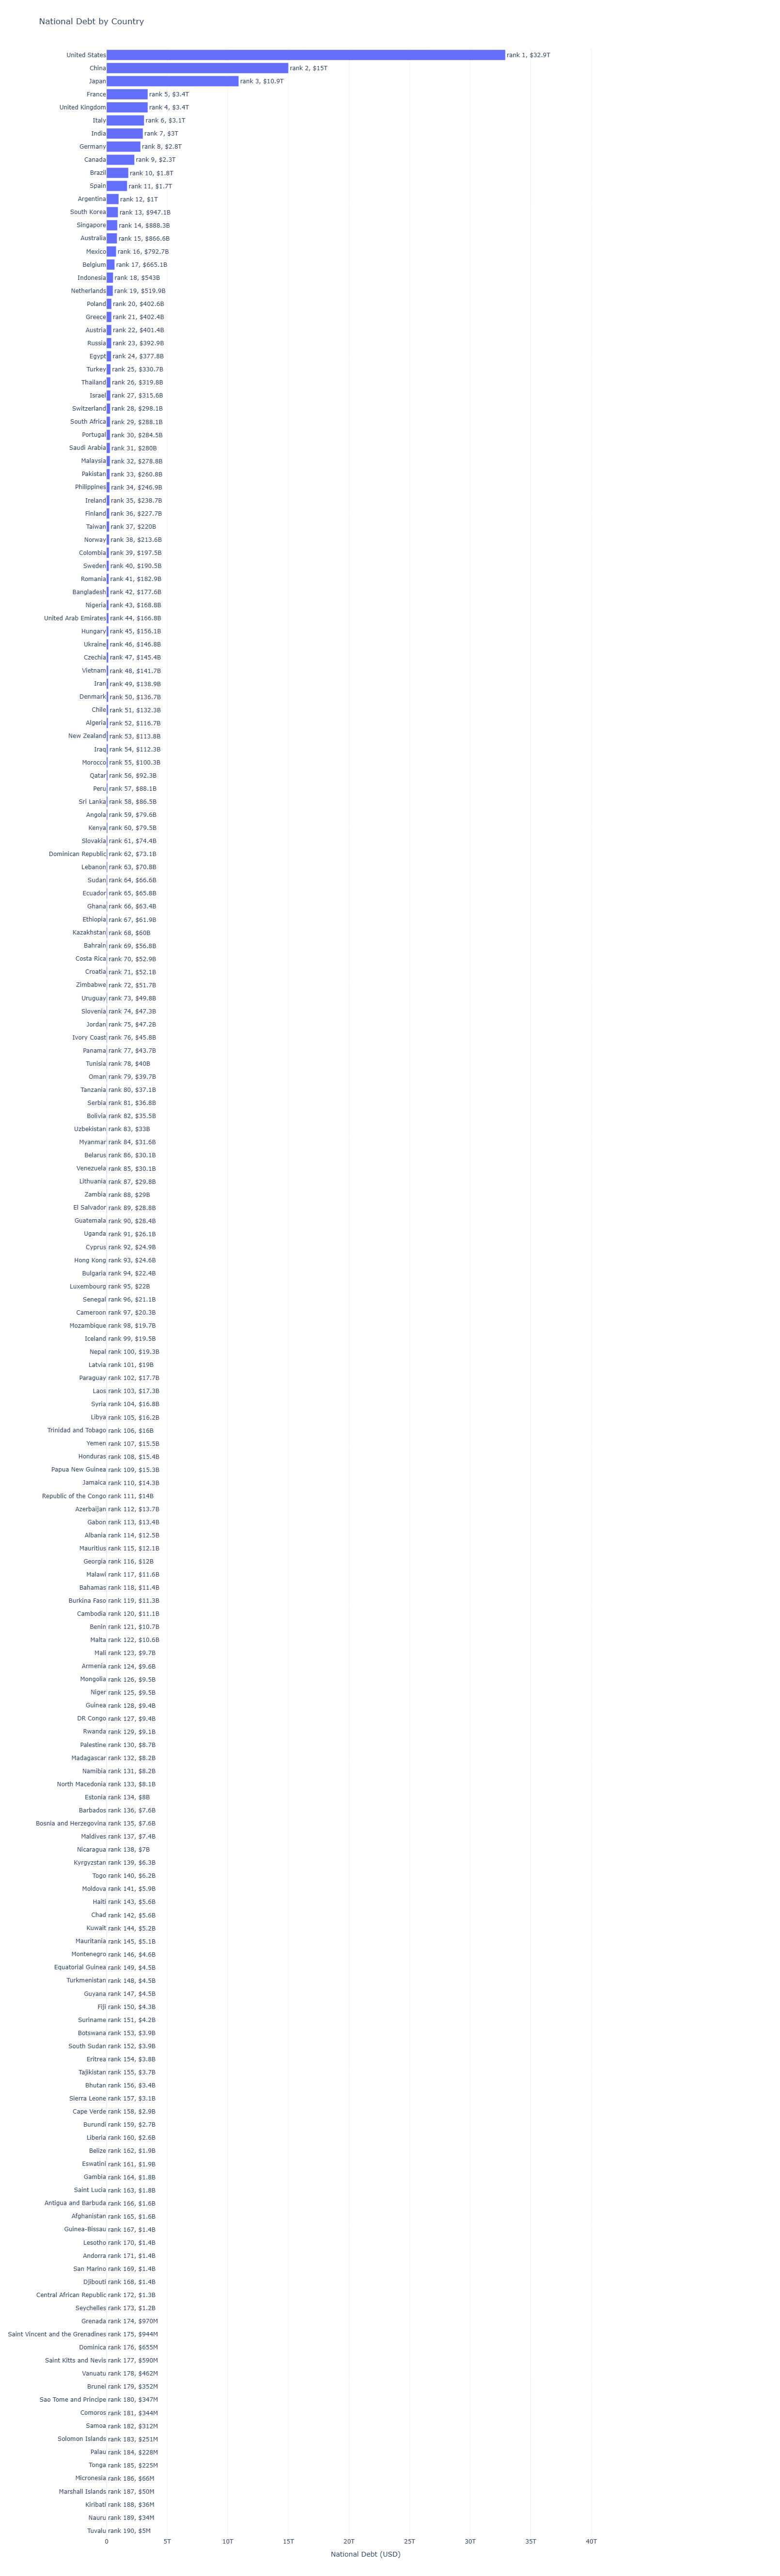

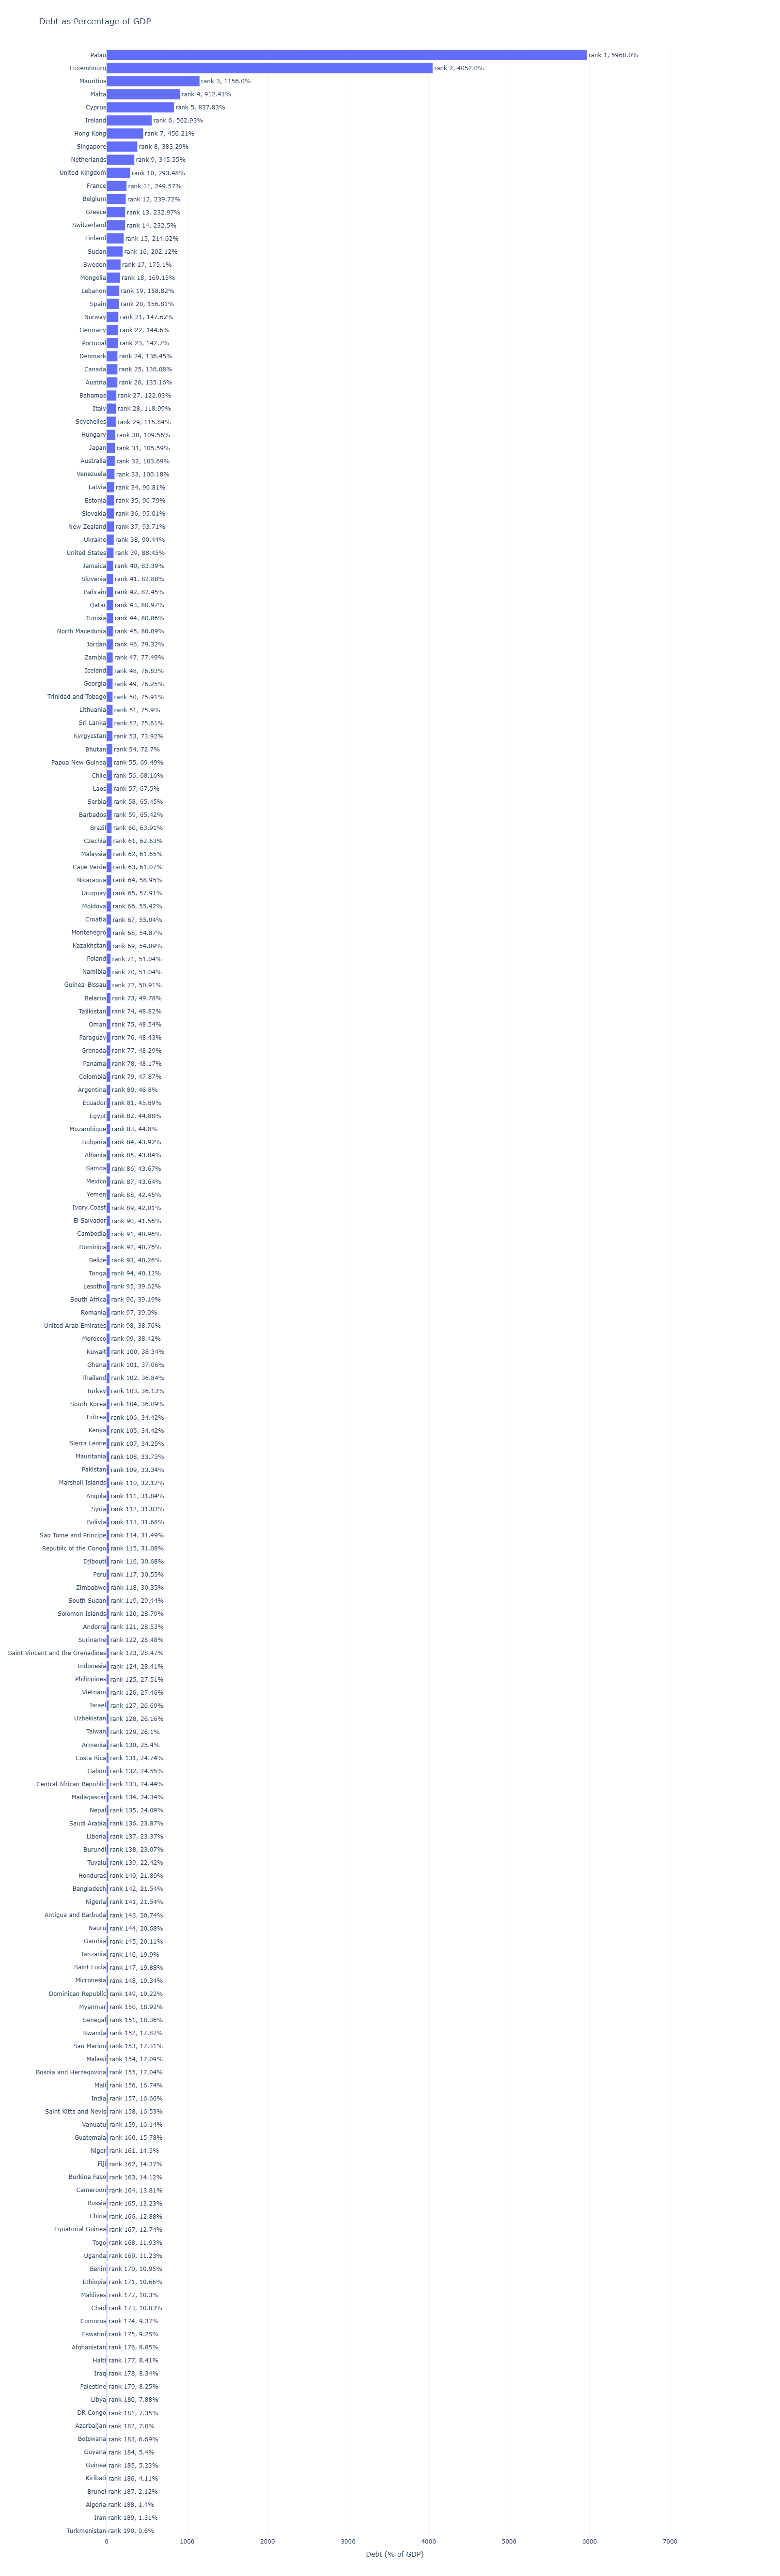

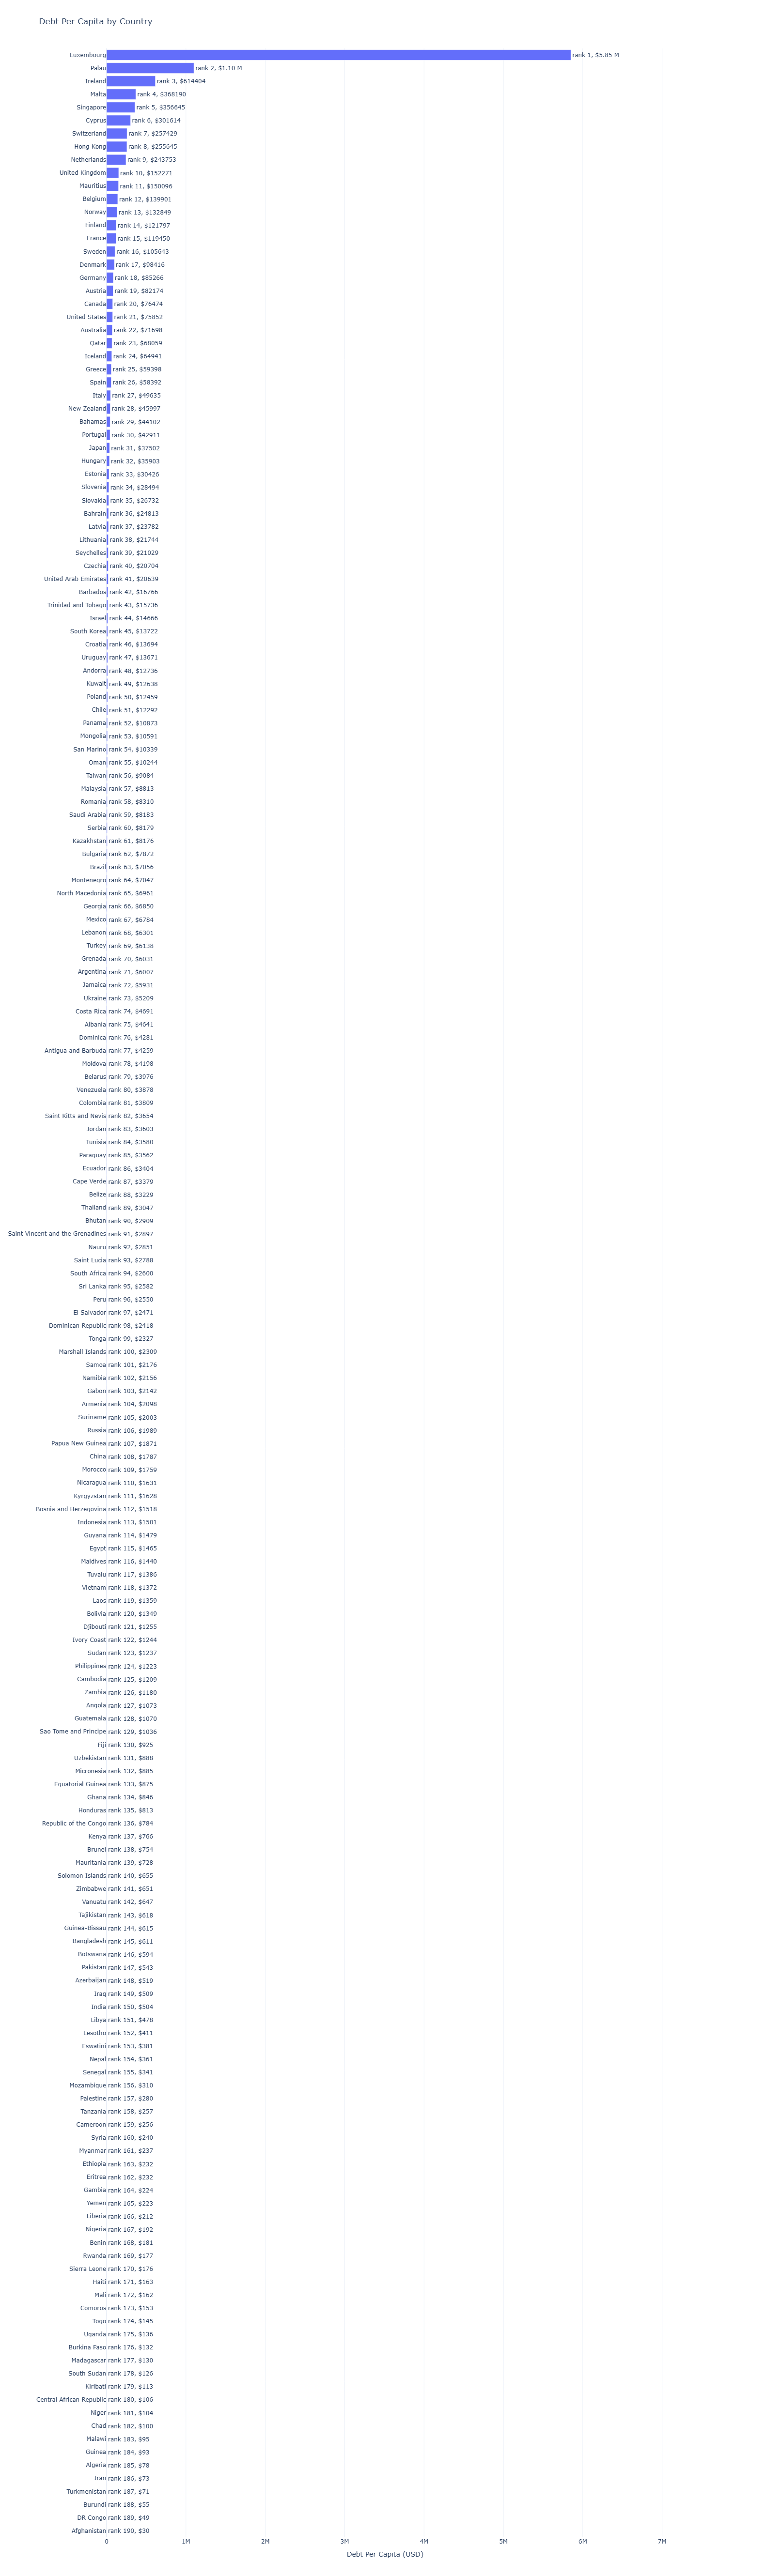

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.graph_objects as go
import re

# fetch the webpage and parse the table
url = "https://worldpopulationreview.com/country-rankings/countries-by-national-debt"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")

table = soup.find("table")
rows = table.find_all("tr")[1:]

# multipliers for debt units
DEBT_MULT = {"T": 1e12, "B": 1e9, "M": 1e6}

records = []

for row in rows:
    cols = row.find_all("td")
    if len(cols) < 5:
        continue

    country = cols[1].text.strip()
    if country.upper() == "TOTAL":
        continue

    debt_text = cols[2].text.strip()
    gdp_pct_text = cols[3].text.strip()
    per_capita_text = cols[4].text.strip()

    # get the debt in USD
    m = re.match(r"\$(\d+(\.\d+)?)([TBM])", debt_text)
    if not m:
        continue
    debt_val = float(m.group(1))
    debt_unit = m.group(3)
    debt_usd = int(debt_val * DEBT_MULT[debt_unit])

    # get debt as % of GDP
    debt_pct_gdp = float(gdp_pct_text.replace("%", "")) if "%" in gdp_pct_text else None

    # get debt per person
    per_capita = None
    pc_text = per_capita_text.replace("$", "").replace(",", "").strip()
    pc_match = re.match(r"(\d+(\.\d+)?)\s*(Mn|Bn)?", pc_text)
    if pc_match:
        pc_val = float(pc_match.group(1))
        pc_unit = pc_match.group(3)
        if pc_unit == "Mn":
            per_capita = int(pc_val * 1_000_000)
        elif pc_unit == "Bn":
            per_capita = int(pc_val * 1_000_000_000)
        else:
            per_capita = int(pc_val)

    records.append({
        "Country": country,
        "Debt Label": debt_text,
        "Debt USD": debt_usd,
        "Debt % GDP": debt_pct_gdp,
        "Debt Per Capita": per_capita
    })

df = pd.DataFrame(records)

# helper to make rank labels for the bars
def create_rank_labels(df, value_col, value_format="raw"):
    df_sorted = df.sort_values(value_col, ascending=False).reset_index(drop=True)
    df_sorted["Rank"] = df_sorted.index + 1

    def format_value(row):
        if value_format == "debt":
            return f"{row['Debt Label']}"
        elif value_format == "pct":
            return f"{row[value_col]}%"
        elif value_format == "percap":
            val = row[value_col]
            if val >= 1e9:
                return f"${val/1e9:.2f} B"
            elif val >= 1e6:
                return f"${val/1e6:.2f} M"
            else:
                return f"${val}"
        else:
            return str(row[value_col])

    df_sorted["Plot Label"] = df_sorted.apply(
        lambda x: f"rank {x['Rank']}, {format_value(x)}", axis=1
    )
    return df_sorted.sort_values(value_col)

# national debt chart
df1_plot = create_rank_labels(df, "Debt USD", "debt")
fig1 = go.Figure(go.Bar(
    x=df1_plot["Debt USD"],
    y=df1_plot["Country"],
    orientation="h",
    text=df1_plot["Plot Label"],
    textposition="outside"
))
fig1.update_layout(
    title="National Debt by Country",
    xaxis_title="National Debt (USD)",
    height=max(600, len(df1_plot)*28),
    margin=dict(l=220, r=320),
    xaxis=dict(range=[0, df1_plot["Debt USD"].max()*1.3]),
    template="plotly_white"
)
fig1.show()

# debt as % of GDP chart
df2 = df.dropna(subset=["Debt % GDP"])
df2_plot = create_rank_labels(df2, "Debt % GDP", "pct")
fig2 = go.Figure(go.Bar(
    x=df2_plot["Debt % GDP"],
    y=df2_plot["Country"],
    orientation="h",
    text=df2_plot["Plot Label"],
    textposition="outside"
))
fig2.update_layout(
    title="Debt as Percentage of GDP",
    xaxis_title="Debt (% of GDP)",
    height=max(600, len(df2_plot)*28),
    margin=dict(l=220, r=200),
    xaxis=dict(range=[0, df2_plot["Debt % GDP"].max()*1.2]),
    template="plotly_white"
)
fig2.show()

# debt per capita chart
df3 = df.dropna(subset=["Debt Per Capita"])
df3_plot = create_rank_labels(df3, "Debt Per Capita", "percap")
fig3 = go.Figure(go.Bar(
    x=df3_plot["Debt Per Capita"],
    y=df3_plot["Country"],
    orientation="h",
    text=df3_plot["Plot Label"],
    textposition="outside"
))
fig3.update_layout(
    title="Debt Per Capita by Country",
    xaxis_title="Debt Per Capita (USD)",
    height=max(600, len(df3_plot)*28),
    margin=dict(l=220, r=240),
    xaxis=dict(range=[0, df3_plot["Debt Per Capita"].max()*1.2]),
    template="plotly_white"
)
fig3.show()
